<p style="padding: 10px;
          color: #7DBCE6;
          text-align: center;
          font-family:Verdana;
          font-size:190%;">
Fuel Consumption EDA & Prediction

</p>


          
<img src="https://media.giphy.com/media/l2R0e9y6A304JkFOg/source.gif"> 

<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p></p><div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home" style = "border:2px solid #7DBCE6;background-color:#7DBCE6; color:white; font-family:Verdana;text-align: center; font-size:120%;">Notebook Content</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Libraries and Utilities<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Load and Check Data<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Exploratory Data Analysis<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Missing Values<span class="badge badge-primary badge-pill">4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#11" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Outliers<span class="badge badge-primary badge-pill">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#12" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Feature Engineering<span class="badge badge-primary badge-pill">6</span></a>
      <a class="list-group-item list-group-item-action" data-toggle="list" href="#16" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Preprocessing<span class="badge badge-primary badge-pill">7</span></a>
      <a class="list-group-item list-group-item-action" data-toggle="list" href="#19" role="tab" aria-controls="settings" target="_self" style = "color:#7DBCE6; font-family:Verdana;text-align: center; font-size:100%;">Modeling<span class="badge badge-primary badge-pill">8</span></a>


</div>
</div>
</div>

<a id = "1"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Libraries and Utilities

In [1]:
!pip install plotly

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from pandas_profiling import ProfileReport
warnings.filterwarnings("ignore")

import seaborn as sns
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from plotly.subplots import make_subplots
%matplotlib inline
colors = ['#7DBCE6','#E6ABE6','#E7E89E','#8FE195','#E28181',
          '#87D8DB','#C2E37D','#DF93A4','#DCB778','#C497DE']
sns.palplot(sns.color_palette(colors))
plt.title('Notebook Colors', size = 12)
plt.axis('off')
plt.show()

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.base import  clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  ElasticNet)

ModuleNotFoundError: No module named 'pandas_profiling'

<a id = "2"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Load and Check Data

In [ ]:
auto_path = '/kaggle/input/autompg-dataset/'

auto = pd.read_csv(os.path.join(auto_path, 'auto-mpg.csv'), na_values = "?")

auto.head()

In [ ]:
def auto_preprocess(dataframe):
    df_ = dataframe.copy()
    auto_misspelled = {'chevroelt': 'chevrolet',
                       'chevy': 'chevrolet',
                       'vokswagen': 'volkswagen',
                       'vw': 'volkswagen',
                       'hi': 'harvester',
                       'maxda': 'mazda',
                       'toyouta': 'toyota',
                       'mercedes-benz': 'mercedes'}
    df_['make'] = [auto_misspelled[key].title() if key in auto_misspelled else
                   key.title() for key in [i.split()[0] for i in df_['car name']]]
    df_['name'] = [' '.join(i.split()[1:]).title() for i in df_['car name']]
    
    df_ = df_.drop(columns = ['car name'], axis = 1)
    return df_

df = auto_preprocess(auto)
df.head()

In [ ]:
 df.profile_report()

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Variable Types

In [ ]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'Classes': [dataframe[i].nunique() \
                                           for i in dataframe.columns]})

    nunique_df = nunique_df.sort_values('Classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Descriptive Statistics

In [ ]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Blues",
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.3,
                cbar = False,
                annot_kws = {"size": 14})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 16)
    plt.show()
    
desc_stats(df[num_cols])

<a id = "3"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Exploratory Data Analysis

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Analysis of Categorical Variables

In [ ]:
def cat_summary(dataframe, col_name):
    
    get_labels = lambda x: x.value_counts().keys()
    get_values = lambda x: x.value_counts().values
    
    fig = make_subplots(rows = 1,cols = 2,
                        subplot_titles = ('Countplot','Percentages'),
                        specs = [[{"type": "xy"}, {'type':'domain'}]])

    fig.add_trace(go.Bar( y = get_values(dataframe[col_name]).tolist(), 
                          x = [str(i) for i in dataframe[col_name].value_counts().index], 
                          text = get_values(dataframe[col_name]).tolist(),
                          textfont = dict(size = 14),
                          name = col_name,
                          textposition = 'auto',
                          marker = dict(color = colors),
                          showlegend=False),
                  row = 1, col = 1)
    
    fig.add_trace(go.Pie(labels = get_labels(dataframe[col_name]),
                         values = get_values(dataframe[col_name]),
                         textfont = dict(size = 14),
                         textposition='auto',
                         showlegend = False,
                         name = col_name,
                         marker = dict(colors = colors)
                        ),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': col_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    iplot(fig)

for col in cat_cols:
    cat_summary(df, col)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Analysis of Numerical Variables

In [ ]:
def num_summary(dataframe, col_name):
    fig = make_subplots(rows=1,cols=2,
                        subplot_titles=('Quantiles','Distribution'))

    fig.add_trace(go.Box(y=dataframe[col_name],
                         name = str(col_name),
                         showlegend = False,
                         marker_color = colors[1]),
                  row = 1, col = 1)
    
    fig.add_trace(go.Histogram(x = dataframe[col_name],
                               xbins = dict(start = dataframe[col_name].min(),
                                            end = dataframe[col_name].max()),
                               showlegend = False,
                               name = str(col_name),
                               marker=dict(color=colors[0],
                                           line=dict(color = '#DBE6EC',
                                                     width = 1))
                              ),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': col_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    iplot(fig)

for i in num_cols:
    num_summary(df,i)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
TOP 10 Horsepower

In [ ]:
fig = px.bar(df[['horsepower','make','name']]. \
             sort_values('horsepower', ascending = False)[:10],
             y = 'name',
             x = 'horsepower',
             text='horsepower',
             labels={'name':'',
                     'horsepower': 'Horsepower',
                     'make': ''},
             color = 'make',
             color_discrete_sequence = colors)

fig.update_layout(title= dict(text = 'TOP 10 Horsepower',
                              x = 0.5,
                              y = 0.95,
                              xanchor = 'center',
                              yanchor = 'top'),
                  xaxis = dict(title = 'Horsepower'),
                  yaxis = dict(categoryorder='total ascending'),
                  font=dict(family='Verdana',
                            size=14,
                            color='black'),
                  template='plotly_white')

fig.show()

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
TOP 10 Weight

In [ ]:
fig = px.bar(df[['weight','make','name']]. \
             sort_values('weight', ascending = False)[:10],
             y = 'name',
             x = 'weight',
             text='weight',
             labels={'name':'',
                     'weight': 'Weight',
                     'make': ''},
             color = 'make',
             color_discrete_sequence = colors)

fig.update_layout(title= dict(text = 'TOP 10 Weight',
                              x = 0.5,
                              y = 0.95,
                              xanchor = 'center',
                              yanchor = 'top'),
                  xaxis = dict(title = 'Weight'),
                  yaxis = dict(categoryorder='total ascending'),
                  font=dict(family='Verdana',
                            size=14,
                            color='black'),
                  template='plotly_white')

fig.show()

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Horsepower - MPG - Cylinders

In [ ]:
data = [go.Scatter(x = df['mpg'],
                   y = df['horsepower'],
                   mode = 'markers',
                   text=df['weight'],
                   marker=dict(size=10,
                               color = df['weight'],
                               showscale=True,
                               colorscale = 'Viridis',
                               colorbar = dict(title='Weight'),
                               opacity=0.8))]

layout = go.Layout(title=dict(text='Horsepower - MPG - Weight',
                              y=0.9,
                              x=0.5,
                              xanchor= 'center',
                              yanchor= 'top'),
                              xaxis = dict(title='MPG'),
                              yaxis =dict(title='Horsepower'),
                   template='plotly_white')

fig = go.Figure(data=data,layout=layout)
iplot(fig)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Horsepower - MPG - Displacement - Weight 

In [ ]:
data = go.Scatter3d(x = df['horsepower'],
                    y = df['mpg'],
                    z = df['displacement'],
                    mode='markers', marker=dict(color=df['weight'],
                                                showscale=True,
                                                colorbar=dict(title='Weight'),
                                                colorscale = 'Viridis',
                                                opacity=0.7))

layout = go.Layout(title = dict(text='Horsepower - MPG - Displacement - Weight',
                                y=0.9,
                                x=0.5,
                                xanchor= 'center',
                                yanchor= 'top'),
                   scene = dict(xaxis = dict(title='Horsepower'),
                                yaxis = dict(title = 'MPG'),
                                zaxis = dict(title='Displacement')),
                   template='plotly_white')

fig = go.Figure(data=data,layout=layout)
iplot(fig)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Pairwise Relationships

In [ ]:
fig = go.Figure(data=go.Splom(dimensions=[dict(label='mpg',
                                               values=df['mpg']),
                                          dict(label='displacement',
                                               values=df['displacement']),
                                          dict(label='horsepower',
                                               values=df['horsepower']),
                                          dict(label='weight',
                                               values=df['weight']),
                                          dict(label='acceleration',
                                               values=df['acceleration']),
                                          dict(label='model year',
                                               values=df['model year'])],
                showupperhalf=True, 
                text=df['cylinders'],
                marker=dict(color = [colors[i] for i in df['cylinders']. \
                                     astype('category').cat.codes],
                            showscale = False,
                            opacity = 0.65)))

fig.update_layout(title = {'text': 'Pairwise Relationships by Cylinders',
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'x': 0.5,
                          'y': 0.95},
                  width=950,
                  height=950,
                  template = 'plotly_white')

iplot(fig)

In [ ]:
fig = go.Figure(data=go.Splom(dimensions=[dict(label='mpg',
                                               values=df['mpg']),
                                          dict(label='displacement',
                                               values=df['displacement']),
                                          dict(label='horsepower',
                                               values=df['horsepower']),
                                          dict(label='weight',
                                               values=df['weight']),
                                          dict(label='acceleration',
                                               values=df['acceleration']),
                                          dict(label='model year',
                                               values=df['model year'])],
                showupperhalf=True, 
                text=df['origin'],
                marker=dict(color = [colors[i] for i in df['origin']. \
                                     astype('category').cat.codes],
                            showscale = False,
                            opacity = 0.65)))

fig.update_layout(title = {'text': 'Pairwise Relationships by Origins',
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'x': 0.5,
                          'y': 0.95},
                  width = 950,
                  height = 950,
                  template = 'plotly_white')

iplot(fig)

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Correlation Coefficients

In [ ]:
def corr_map(dataframe, method = 'pearson', title = None):
    assert method in ['pearson', 'spearman'], 'Invalid Correlation Method'
    sns.set_style("white")
    matrix = np.triu(dataframe.corr(method=method))
    f,ax=plt.subplots(figsize = (matrix.shape[0]*0.75,
                                 matrix.shape[1]*0.75))
    sns.heatmap(dataframe.corr(method=method),
                annot= True,
                fmt = ".2f",
                cbar = False,
                ax=ax,
                vmin = -1,
                vmax = 1,
                mask = matrix,
                cmap = "Blues",
                linewidth = 0.4,
                linecolor = "white",
                annot_kws={"size": 12})
    plt.xticks(rotation=80,size=14)
    plt.yticks(rotation=0,size=14)
    if title == None:
        title = f'{method.title()} Correlation Map'
    plt.title(title, size = 14)
    plt.show()
    
corr_map(df)

<a id = "4"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Missing Values

In [ ]:
def check_missing(dataframe):
    
    missing = pd.DataFrame({'Variable': dataframe.columns,
                           'Missing': [dataframe[i].isnull().sum() for i in dataframe.columns],
                           'Ratio': [100 * dataframe[i].isnull().sum() / dataframe.shape[0] \
                                    for i in dataframe.columns]})
    missing = missing[missing['Missing'] > 0]
    
    if missing.shape[0] == 0:
        print('No missing values')
    else:
        missing = missing.reset_index(drop = True)
        missing = missing.sort_values('Missing', ascending = False)
        return missing
    
check_missing(df)

In [ ]:
df.groupby(cat_cols).agg({'horsepower': ['mean','median']})

In [ ]:
df['horsepower'] = df['horsepower'].fillna(df.groupby(cat_cols) \
                                           ['horsepower'].transform('median'))

check_missing(df)

<a id = "11"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Outliers

In [ ]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1 = q1, q3 = q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in df[num_cols].columns:
    replace_with_thresholds(df, col, q1 = 0.1, q3 = 0.9)
    
desc_stats(df[num_cols])

<img src="https://media.giphy.com/media/sDCma70RplcNG/giphy.gif">

<a id = "12"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Feature Engineering
    
<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
MPG (Dependent Variable)

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (8,6))
sns.distplot(df.mpg, fit= norm)
plt.show()

In [ ]:
(mu, sigma) = norm.fit(df["mpg"])
print("mu: {} sigma = {}".format(mu, sigma))

In [ ]:
fig = plt.figure(figsize = (8,6))
stats.probplot(df["mpg"], plot = plt)
plt.title("Before Log1p Transformation", size = 12)
plt.show()

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Log1p Transformation
    
$$\Huge y_i = {\log_e (x_i+1)} $$
    
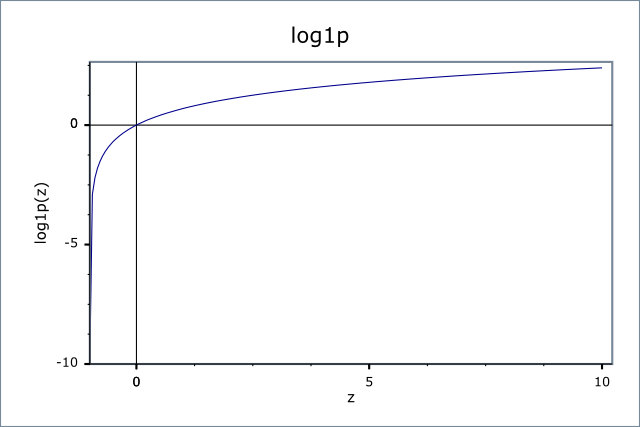

In [ ]:
df["mpg"] = np.log1p(df["mpg"])
plt.figure(figsize = (8,6))
sns.distplot(df.mpg, fit= norm)
plt.show()

In [ ]:
(mu, sigma) = norm.fit(df["mpg"])
print("mu: {} sigma = {}".format(mu, sigma))

In [ ]:
fig = plt.figure(figsize = (8,6))
stats.probplot(df["mpg"], plot = plt)
plt.title("After Log1p Transformation", size = 12)
plt.show()

<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Encoding

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns = categorical_cols,
                               drop_first = drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
print('Binary Variables: {}'.format(binary_cols))

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols.append('make')
print('Multiclass Variables: {}'.format(ohe_cols))

In [ ]:
df['cylinders'] = df['cylinders'].astype(int)
df['origin'] = df['origin'].astype(int)
df = one_hot_encoder(df, ohe_cols)
df.head()

In [ ]:
check_class(df)

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

rare_analyser(df, cat_cols)

In [ ]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.03).any(axis=None)]

print('Number of useless variables: {}'.format(len(useless_cols)))
df.drop(useless_cols, axis=1, inplace=True)

In [ ]:
corr_map(df)

<img src="https://media.giphy.com/media/6swcfDQHr3UTm/giphy.gif">

<a id = "16"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Preprocessing
    
<span style="color:#7DBCE6;
             font-size:130%;
             font-family:Verdana;">
Train-Test Split

In [ ]:
X = df.drop(columns = ["mpg", 'name'], axis = 1)
y = df['mpg']
X.head()

In [ ]:
test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size  = test_size,
                                                    random_state = random_state)

<a id = "19"></a>
<span style="color:#7DBCE6;
             font-size:150%;
             font-family:Verdana;">
Modeling

In [ ]:
def train_pipeline(pipe):
    
    scaler = pipe.steps[0][1].__class__.__name__
    regressor = pipe.steps[1][1].__class__.__name__
    if scaler == 'NoneType':
        scaler = 'Without Scaling'
    print(f'Regressor: {regressor} & Scaler: {scaler}')
    
    #Fitting Model
    pipe.fit(X_train, y_train)
    
    #Get Predictions
    y_pred = pipe.predict(X_test)
    
    #Model Evaluation
    print(f'R-Squared: {round(r2_score(y_test, y_pred), 6)}')
    print(f'RMSE: {round(mean_squared_error(y_test, y_pred, squared = False), 6)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 6)}\n')
    
regressors = [KNeighborsRegressor(),
               LinearRegression(),
               Lasso(),
               Ridge(),
               ElasticNet(),
               XGBRegressor(),
               LGBMRegressor()]

scalers = [None, StandardScaler(), RobustScaler()]

for reg in regressors:
    for sc in scalers:
        pipeline = Pipeline([('scaler', sc), ('reg', reg)])
        train_pipeline(pipeline)

<span style="color:#7DBCE6;
             font-size:110%;
             font-family:Verdana;">
If you liked this notebook, please upvote 😊
    
<span style="color:#7DBCE6;
             font-size:110%;
             font-family:Verdana;">
If you have any suggestions or questions, feel free to comment!
    
<span style="color:#7DBCE6;
             font-size:110%;
             font-family:Verdana;">
Best Wishes!

